In [57]:
# prerequisites
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from scipy.stats import norm
from sklearn.metrics import roc_curve,roc_auc_score

In [153]:
# data load
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr, x_te = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)

#Our mystery digit will be 9

#Now lets prepare a search where we just have 5 and 9
x_te5 = x_te[(y_te == 5)]
y_te5 = y_te[(y_te == 5)]
x_tr5 = x_tr[(y_tr == 5)]
y_tr5 = y_tr[(y_tr == 5)]

x_te9 = x_te[(y_te == 9)]
y_te9 = y_te[(y_te == 9)]
x_tr9 = x_tr[(y_tr == 9)]
y_tr9 = y_tr[(y_tr == 9)]

#And merge
x_te59 = x_te[np.logical_or((y_te == 5),(y_te == 9))]
y_te59 = y_te[np.logical_or((y_te == 5),(y_te == 9))]
x_tr59 = x_tr[np.logical_or((y_tr == 5),(y_tr == 9))]
y_tr59 = y_tr[np.logical_or((y_tr == 5),(y_tr == 9))]
y_te59 = np.eye(2)[((y_te59-5)*0.25).astype(int)]
y_tr59 = np.eye(2)[((y_tr59-5)*0.25).astype(int)]

#Now lets prepare a search where we just have 5,6 and 9
x_te6 = x_te[(y_te == 6)]
y_te6 = y_te[(y_te == 6)]
x_tr6 = x_tr[(y_tr == 6)]
y_tr6 = y_tr[(y_tr == 6)]

#Now lets prepare a dataset with all the digits except 9
x_ten6 = x_te[np.logical_not(y_te==9)]
y_ten6 = y_te[np.logical_not(y_te==9)]
x_trn6 = x_tr[np.logical_not(y_tr==9)]
y_trn6 = y_tr[np.logical_not(y_tr==9)]

x_ten6 = x_ten6[np.logical_not(y_ten6==6)]
y_ten6 = y_ten6[np.logical_not(y_ten6==6)]
x_trn6 = x_trn6[np.logical_not(y_trn6==6)]
y_trn6 = y_trn6[np.logical_not(y_trn6==6)]



In [497]:
#now lets make the model
batch_size, n_epoch = 1, 15
n_hidden, z_dim = 256, 4

# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

#VAE Model
def makeModel(ix_tr):
    # encoder
    x = Input(shape=(ix_tr.shape[1:]))
    x_encoded = Dense(n_hidden, activation='relu')(x)
    x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)

    mu = Dense(z_dim)(x_encoded)
    log_var = Dense(z_dim)(x_encoded)
    z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])    

    # decoder
    z_decoder1 = Dense(n_hidden//2, activation='relu')
    z_decoder2 = Dense(n_hidden, activation='relu')
    y_decoder = Dense(x_tr.shape[1], activation='sigmoid')

    z_decoded = z_decoder1(z)
    z_decoded = z_decoder2(z_decoded)
    y = y_decoder(z_decoded)
    
    # loss
    reconstruction_loss = objectives.binary_crossentropy(x, y) * x_tr.shape[1]
    kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
    vae_loss = reconstruction_loss + kl_loss
    
    vae = Model(x, y)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')
    #vae.summary()
    
    # build decoder
    decoder_input = Input(shape=(z_dim,))
    _z_decoded    = z_decoder1(decoder_input)
    _z_decoded    = z_decoder2(_z_decoded)
    _y            = y_decoder(_z_decoded)
    generator = Model(decoder_input, _y)
    return vae,generator,x,y,mu,vae_loss

#Classifier Model
def classifierModel(ix_tr):
    n_hidden=16
    x = Input(shape=(ix_tr.shape[1:]))
    x_encoded = Dense(n_hidden, activation='relu')(x)
    x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)
    x_encoded = Dense(8, activation='relu')(x_encoded)
    y = Dense(2, activation='softmax')(x_encoded)
    classifier = Model(x, y)
    classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return classifier,x,y

In [36]:
#Now lets train a VAE on just 5
vae5,gen5,x5,y5,mu5,vae_loss5 = makeModel(x_tr5)
vae5.fit(x_tr5,
       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       validation_data=(x_te5, None), verbose=1)

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_105 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_105.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 5421 samples, validate on 892 samples
Epoch 1/15
5421/5421 [==============================] - 12s 2ms/step - loss: 145.3368 - val_loss: 135.5213
Epoch 2/15
5421/5421 [==============================] - 11s 2ms/step - loss: 133.3555 - val_loss: 132.4523
Epoch 3/15
5421/5421 [==============================] - 10s 2ms/step - loss: 132.3157 - val_loss: 132.7234
Epoch 4/15
5421/5421 [==============================] - 11s 2ms/step - loss: 131.9855 - val_loss: 133.6949
Epoch 5/15
5421/5421 [==============================] - 12s 2ms/step - loss: 131.9524 - val_loss: 132.6112
Epoch 6/15
5421/5421 [==============================] - 12s 2ms/step - loss: 132.1239 - val_loss: 133.4001
Epoch 7/15
5421/5421 [==============================] - 11s 2ms/step - loss: 132.3805 - val_loss: 132.8373
Epoch 8/15
5421/5421 [==============================] - 13s 2ms/step - loss: 132.4604 - val_loss: 133.8524
Epoch 9/15
5421/5421 [==============================] - 13s 2ms/step - loss: 132.7825 - val_loss:

In [123]:
#Now lets train a VAE on just 9
vae9,gen9,x9,y9,mu9,vae_loss9 = makeModel(x_tr9)
vae9.fit(x_tr9,
       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       validation_data=(x_te9, None), verbose=1)

#Also lets do a full classifier on 5 vs 9
model_full59,x_full59,y_full59 = classifierModel(x_tr59)
model_full59.fit(x_tr59,y_tr59,
                 shuffle=True,
                 epochs=50,
                 batch_size=20,
                 validation_data=(x_te59, y_te59), verbose=1)

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_138 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_138.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 5949 samples, validate on 1009 samples
Epoch 1/15
5949/5949 [==============================] - 15s 2ms/step - loss: 121.0308 - val_loss: 109.6290
Epoch 2/15
5949/5949 [==============================] - 12s 2ms/step - loss: 108.8034 - val_loss: 106.5370
Epoch 3/15
5949/5949 [==============================] - 12s 2ms/step - loss: 107.2861 - val_loss: 106.3801
Epoch 4/15
5949/5949 [==============================] - 12s 2ms/step - loss: 106.9731 - val_loss: 105.7097
Epoch 5/15
5949/5949 [==============================] - 12s 2ms/step - loss: 106.9747 - val_loss: 106.2995
Epoch 6/15
5949/5949 [==============================] - 12s 2ms/step - loss: 107.0474 - val_loss: 105.9667
Epoch 7/15
5949/5949 [==============================] - 12s 2ms/step - loss: 107.1844 - val_loss: 106.5611
Epoch 8/15
5949/5949 [==============================] - 12s 2ms/step - loss: 107.5001 - val_loss: 108.1993
Epoch 9/15
5949/5949 [==============================] - 12s 2ms/step - loss: 107.5887 - val_loss

Epoch 44/50
11370/11370 [==============================] - 1s 96us/step - loss: 1.5989e-10 - accuracy: 1.0000 - val_loss: 0.0373 - val_accuracy: 0.9953
Epoch 45/50
11370/11370 [==============================] - 1s 94us/step - loss: 1.1009e-10 - accuracy: 1.0000 - val_loss: 0.0374 - val_accuracy: 0.9958
Epoch 46/50
11370/11370 [==============================] - 1s 97us/step - loss: 7.0771e-11 - accuracy: 1.0000 - val_loss: 0.0376 - val_accuracy: 0.9953
Epoch 47/50
11370/11370 [==============================] - 1s 97us/step - loss: 3.6696e-11 - accuracy: 1.0000 - val_loss: 0.0379 - val_accuracy: 0.9953
Epoch 48/50
11370/11370 [==============================] - 1s 96us/step - loss: 2.6211e-11 - accuracy: 1.0000 - val_loss: 0.0380 - val_accuracy: 0.9953
Epoch 49/50
11370/11370 [==============================] - 1s 99us/step - loss: 1.5727e-11 - accuracy: 1.0000 - val_loss: 0.0381 - val_accuracy: 0.9953
Epoch 50/50
11370/11370 [==============================] - 1s 98us/step - loss: 1.0485e-

In [126]:
fpr = dict()
tpr = dict()

#now lets compare the loss functions between 5 and 9
def vaeloss(vaemodel,ix):
        result = objectives.binary_crossentropy(ix,vaemodel.predict(ix, batch_size=batch_size))* ix.shape[1]
        return result

def plot_roc_curve(y_ml,y,fpr,tpr,iLabel,iReverse=False):
    fpr , tpr , thresholds = roc_curve ( y[:,0] , y_ml)
    #plt.semilogx(fpr,tpr) 
    if iReverse:
        plt.plot(fpr,tpr,label=iLabel) 
    else:
        plt.plot(tpr,fpr,label=iLabel) 
    plt.axis([0,1,0,1]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    auc_score=roc_auc_score( y[:,0], y_ml)  #0.8822
    print(auc_score)


In [124]:
#Now lets build a discriminator just using the loss infos

#First we build the loss data
x_tr59_loss5 = vaeloss(vae5,x_tr59)
x_tr59_loss9 = vaeloss(vae9,x_tr59)
x_te59_loss5 = vaeloss(vae5,x_te59)
x_te59_loss9 = vaeloss(vae9,x_te59)
#merge and 5 & 9
x_te59_loss59    = np.transpose(np.array([x_te59_loss5,x_te59_loss9]))
x_tr59_loss59    = np.transpose(np.array([x_tr59_loss5,x_tr59_loss9]))

#Now train this guy
model_loss59,x_loss59,y_loss59 = classifierModel(x_tr59_loss59)
model_loss59.fit(x_tr59_loss59,y_tr59,
                 shuffle=True,
                 epochs=50,
                 batch_size=20,
                 validation_data=(x_te59_loss59, y_te59), verbose=1)

Train on 11370 samples, validate on 1901 samples
Epoch 1/50
11370/11370 [==============================] - 1s 70us/step - loss: 0.4503 - accuracy: 0.9633 - val_loss: 0.2803 - val_accuracy: 0.9769
Epoch 2/50
11370/11370 [==============================] - 1s 55us/step - loss: 0.1853 - accuracy: 0.9818 - val_loss: 0.3084 - val_accuracy: 0.9721
Epoch 3/50
11370/11370 [==============================] - 1s 55us/step - loss: 0.1126 - accuracy: 0.9803 - val_loss: 0.1233 - val_accuracy: 0.9779
Epoch 4/50
11370/11370 [==============================] - 1s 57us/step - loss: 0.0613 - accuracy: 0.9817 - val_loss: 0.0821 - val_accuracy: 0.9774
Epoch 5/50
11370/11370 [==============================] - 1s 55us/step - loss: 0.0596 - accuracy: 0.9823 - val_loss: 0.0828 - val_accuracy: 0.9769
Epoch 6/50
11370/11370 [==============================] - 1s 59us/step - loss: 0.0571 - accuracy: 0.9826 - val_loss: 0.0896 - val_accuracy: 0.9769
Epoch 7/50
11370/11370 [==============================] - 1s 63us/ste

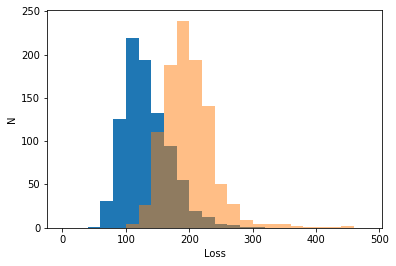

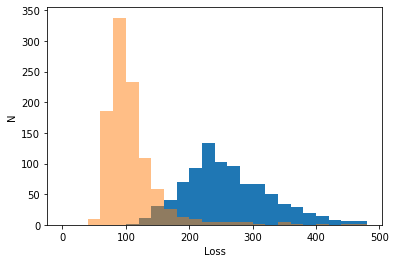

0.10115796397445412
0.9752118822969953
0.9963834458483514
0.9989533658952833


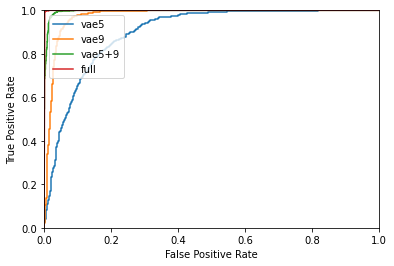

In [128]:
#Lets compute the VAE Loss for 5
x5_loss5 = vaeloss(vae5,x_te5)
x9_loss5 = vaeloss(vae5,x_te9)
x59_loss5 = vaeloss(vae5,x_te59)

bins=np.arange(0,500,20)
plt.hist(x5_loss5,bins)
plt.hist(x9_loss5,bins,alpha=0.5)
plt.xlabel('Loss') 
plt.ylabel('N') 
plt.show()

#Lets compute the VAE Loss for 5 and 9
x5_loss9 = vaeloss(vae9,x_te5)
x9_loss9 = vaeloss(vae9,x_te9)
x59_loss9 = vaeloss(vae9,x_te59)

bins=np.arange(0,500,20)
plt.hist(x5_loss9,bins)
plt.hist(x9_loss9,bins,alpha=0.5)
plt.xlabel('Loss') 
plt.ylabel('N') 
plt.show()

#Now some rocs, lets compare the single VAE loss with the double loss and full
y_pred_loss59 = model_loss59.predict(x_te59_loss59)
y_pred_full59 = model_full59.predict(x_te59)

plot_roc_curve(x59_loss5,y_te59,fpr,tpr,'vae5')
plot_roc_curve(x59_loss9,y_te59,fpr,tpr,'vae9',True)
plot_roc_curve(y_pred_loss59[:,0],y_te59,fpr,tpr,'vae5+9',True)
plot_roc_curve(y_pred_full59[:,0],y_te59,fpr,tpr,'full',True)
plt.legend(loc="upper left")
plt.show()


In [129]:
#Now lets repeat the same study where we replace 9 with 6
vae6,gen6,x6,y6,mu6,vae_loss6 = makeModel(x_tr6)
vae6.fit(x_tr6,
       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       validation_data=(x_te6, None), verbose=1)


/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_153 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_153.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 5918 samples, validate on 958 samples
Epoch 1/15
5918/5918 [==============================] - 14s 2ms/step - loss: 131.1889 - val_loss: 121.9992
Epoch 2/15
5918/5918 [==============================] - 14s 2ms/step - loss: 117.3143 - val_loss: 120.0803
Epoch 3/15
5918/5918 [==============================] - 13s 2ms/step - loss: 115.7146 - val_loss: 119.5043
Epoch 4/15
5918/5918 [==============================] - 14s 2ms/step - loss: 115.1849 - val_loss: 117.4089
Epoch 5/15
5918/5918 [==============================] - 13s 2ms/step - loss: 115.0447 - val_loss: 117.7948
Epoch 6/15
5918/5918 [==============================] - 13s 2ms/step - loss: 115.0593 - val_loss: 117.7454
Epoch 7/15
5918/5918 [==============================] - 13s 2ms/step - loss: 115.1041 - val_loss: 118.5257
Epoch 8/15
5918/5918 [==============================] - 13s 2ms/step - loss: 115.0995 - val_loss: 120.3097
Epoch 9/15
5918/5918 [==============================] - 13s 2ms/step - loss: 115.2417 - val_loss:

In [135]:
#Now lets build a discriminator of 5 vs 6
x_te56 = x_te[np.logical_or((y_te == 5),(y_te == 6))]
y_te56 = y_te[np.logical_or((y_te == 5),(y_te == 6))]
x_tr56 = x_tr[np.logical_or((y_tr == 5),(y_tr == 6))]
y_tr56 = y_tr[np.logical_or((y_tr == 5),(y_tr == 6))]
y_te56 = np.eye(2)[((y_te56-5)).astype(int)]
y_tr56 = np.eye(2)[((y_tr56-5)).astype(int)]

#First we build the loss data
x_tr56_loss5 = vaeloss(vae5,x_tr56)
x_tr56_loss6 = vaeloss(vae6,x_tr56)
x_te56_loss5 = vaeloss(vae5,x_te56)
x_te56_loss6 = vaeloss(vae6,x_te56)
#merge and 5 & 9
x_te56_loss56    = np.transpose(np.array([x_te56_loss5,x_te56_loss6]))
x_tr56_loss56    = np.transpose(np.array([x_tr56_loss5,x_tr56_loss6]))
print (x_tr56_loss56)

#Now train this guy
model_loss56,x_loss56,y_loss56 = classifierModel(x_tr56_loss56)
model_loss56.fit(x_tr56_loss56,y_tr56,
                 shuffle=True,
                 epochs=50,
                 batch_size=20,
                 validation_data=(x_te56_loss56, y_te56), verbose=1)

[[194.33313 383.50006]
 [ 80.00855 244.9273 ]
 [251.19089 103.89564]
 ...
 [112.71128 209.58936]
 [128.25969 383.63702]
 [242.07178 139.24426]]
Train on 11339 samples, validate on 1850 samples
Epoch 1/50
11339/11339 [==============================] - 1s 70us/step - loss: 0.1362 - accuracy: 0.9690 - val_loss: 0.0695 - val_accuracy: 0.9595
Epoch 2/50
11339/11339 [==============================] - 1s 54us/step - loss: 0.0853 - accuracy: 0.9719 - val_loss: 0.0852 - val_accuracy: 0.9811
Epoch 3/50
11339/11339 [==============================] - 1s 54us/step - loss: 0.0673 - accuracy: 0.9783 - val_loss: 0.0594 - val_accuracy: 0.9822
Epoch 4/50
11339/11339 [==============================] - 1s 54us/step - loss: 0.0556 - accuracy: 0.9813 - val_loss: 0.0733 - val_accuracy: 0.9746
Epoch 5/50
11339/11339 [==============================] - 1s 57us/step - loss: 0.0558 - accuracy: 0.9821 - val_loss: 0.0542 - val_accuracy: 0.9827
Epoch 6/50
11339/11339 [==============================] - 1s 56us/step -

In [143]:
x_tr59_loss5 = vaeloss(vae5,x_tr59)
x_tr59_loss6 = vaeloss(vae6,x_tr59)
x_te59_loss5 = vaeloss(vae5,x_te59)
x_te59_loss6 = vaeloss(vae6,x_te59)
#merge and 5 & 9
x_te59_loss56    = np.transpose(np.array([x_te59_loss5,x_te59_loss6]))
x_tr59_loss56    = np.transpose(np.array([x_tr59_loss5,x_tr59_loss6]))
#Now in this 2D space we train a discrimintor
model_59loss56,x_59loss56,y_59loss56 = classifierModel(x_tr59_loss56)
model_59loss56.fit(x_tr59_loss56,y_tr59,
                 shuffle=True,
                 epochs=10,
                 batch_size=1,
                 validation_data=(x_te59_loss56, y_te59), verbose=1)


Train on 11370 samples, validate on 1901 samples
Epoch 1/10
11370/11370 [==============================] - 12s 1ms/step - loss: 0.4743 - accuracy: 0.7936 - val_loss: 0.3795 - val_accuracy: 0.8296
Epoch 2/10
11370/11370 [==============================] - 12s 1ms/step - loss: 0.3809 - accuracy: 0.8310 - val_loss: 0.3391 - val_accuracy: 0.8438
Epoch 3/10
11370/11370 [==============================] - 12s 1ms/step - loss: 0.3443 - accuracy: 0.8488 - val_loss: 0.3183 - val_accuracy: 0.8685
Epoch 4/10
11370/11370 [==============================] - 12s 1ms/step - loss: 0.3279 - accuracy: 0.8617 - val_loss: 0.3598 - val_accuracy: 0.8364
Epoch 5/10
11370/11370 [==============================] - 12s 1ms/step - loss: 0.3219 - accuracy: 0.8685 - val_loss: 0.2901 - val_accuracy: 0.8880
Epoch 6/10
11370/11370 [==============================] - 13s 1ms/step - loss: 0.3152 - accuracy: 0.8721 - val_loss: 0.2954 - val_accuracy: 0.8738
Epoch 7/10
11370/11370 [==============================] - 12s 1ms/ste

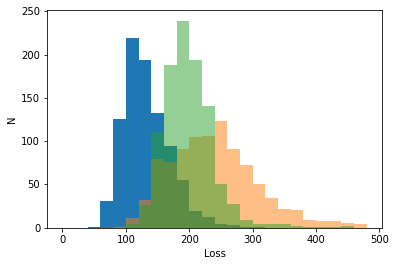

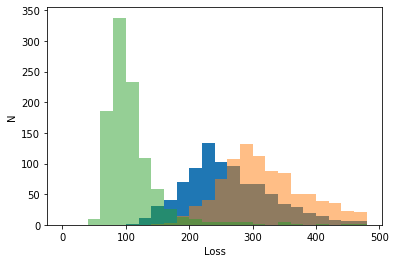

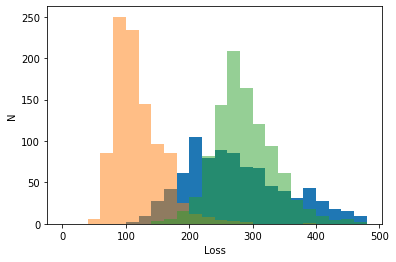

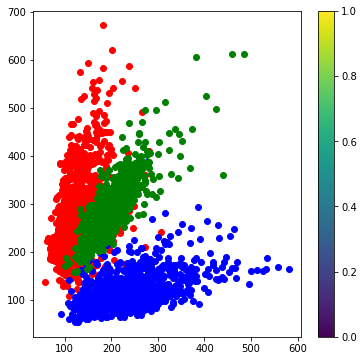

0.10115796397445412
0.4341720479807295
0.9752118822969953
0.7667883665841507
0.9488460359011054
0.9963834458483514
0.9989533658952833


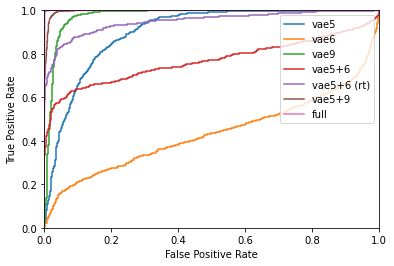

In [145]:
#Now we make the same plots with 6  

#Lets compute the VAE Loss for 5
x5_loss5 = vaeloss(vae5,x_te5)
x6_loss5 = vaeloss(vae5,x_te6)
x9_loss5 = vaeloss(vae5,x_te9)
x59_loss5= vaeloss(vae5,x_te59)

bins=np.arange(0,500,20)
plt.hist(x5_loss5,bins)
plt.hist(x6_loss5,bins,alpha=0.5)
plt.hist(x9_loss5,bins,alpha=0.5)
plt.xlabel('Loss') 
plt.ylabel('N') 
plt.show()

#Lets compute the VAE Loss for 5,6 and 9
x5_loss9 = vaeloss(vae9,x_te5)
x6_loss9 = vaeloss(vae9,x_te6)
x9_loss9 = vaeloss(vae9,x_te9)
x59_loss9= vaeloss(vae9,x_te59)

bins=np.arange(0,500,20)
plt.hist(x5_loss9,bins)
plt.hist(x6_loss9,bins,alpha=0.5)
plt.hist(x9_loss9,bins,alpha=0.5)
plt.xlabel('Loss') 
plt.ylabel('N') 
plt.show()

#Lets compute the VAE Loss for 5 and 9
x5_loss6 = vaeloss(vae6,x_te5)
x6_loss6 = vaeloss(vae6,x_te6)
x9_loss6 = vaeloss(vae6,x_te9)
x59_loss6= vaeloss(vae6,x_te59)

bins=np.arange(0,500,20)
plt.hist(x5_loss6,bins)
plt.hist(x6_loss6,bins,alpha=0.5)
plt.hist(x9_loss6,bins,alpha=0.5)
plt.xlabel('Loss') 
plt.ylabel('N') 
plt.show()

#Lets now make the 2D plot
plt.figure(figsize=(6, 6))
plt.scatter(x5_loss5, x5_loss6, c='r')
plt.scatter(x6_loss5, x6_loss6, c='b')
plt.scatter(x9_loss5, x9_loss6, c='g')
plt.colorbar()
plt.show()


#Now some rocs, lets compare the single VAE loss with the double loss and full
y_pred_loss56 = model_loss56.predict(x_te59_loss56)
y_pred_59loss56 = model_59loss56.predict(x_te59_loss56)
y_pred_loss59 = model_loss59.predict(x_te59_loss59)
y_pred_full59 = model_full59.predict(x_te59)

plot_roc_curve(x59_loss5,y_te59,fpr,tpr,'vae5')
plot_roc_curve(x59_loss6,y_te59,fpr,tpr,'vae6',True)
plot_roc_curve(x59_loss9,y_te59,fpr,tpr,'vae9',True)
plot_roc_curve(y_pred_loss56[:,0],y_te59,fpr,tpr,'vae5+6',True)
plot_roc_curve(y_pred_59loss56[:,0],y_te59,fpr,tpr,'vae5+6 (rt)',True)
plot_roc_curve(y_pred_loss59[:,0],y_te59,fpr,tpr,'vae5+9',True)
plot_roc_curve(y_pred_full59[:,0],y_te59,fpr,tpr,'full',True)
plt.legend(loc="upper right")
plt.show()

In [154]:
#Now lets try to discover 9 knowing all the other numbers
#To do this we train with all number except 6 and 9 
vaen6,genn6,xn6,yn6,mun6,vae_lossn6 = makeModel(x_trn6)
vaen6.fit(x_trn6,
       shuffle=True,
       epochs=5,
       batch_size=batch_size,
       validation_data=(x_ten6, None), verbose=1)

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_202 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_202.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 48133 samples, validate on 8033 samples
Epoch 1/5
48133/48133 [==============================] - 92s 2ms/step - loss: 145.6871 - val_loss: 141.7113
Epoch 2/5
48133/48133 [==============================] - 88s 2ms/step - loss: 143.4001 - val_loss: 142.3826
Epoch 3/5
48133/48133 [==============================] - 88s 2ms/step - loss: 144.3133 - val_loss: 144.7769
Epoch 4/5
48133/48133 [==============================] - 89s 2ms/step - loss: 145.2345 - val_loss: 144.1009
Epoch 5/5
48133/48133 [==============================] - 88s 2ms/step - loss: 146.4776 - val_loss: 146.5929


In [243]:
#Now lets build a discriminator of 5 vs 6
y_teI9 = np.eye(2)[((y_te==9)).astype(int)]
y_trI9 = np.eye(2)[((y_tr==9)).astype(int)]

#First we build the loss data
x_tr_lossn6 = vaeloss(vaen6,x_tr)
x_tr_loss6  = vaeloss(vae6 ,x_tr)
x_te_lossn6 = vaeloss(vaen6,x_te)
x_te_loss6  = vaeloss(vae6 ,x_te)

#merge and 5 & 9
x_te_loss6n6    = np.transpose(np.array([x_te_loss6,x_te_lossn6]))
x_tr_loss6n6    = np.transpose(np.array([x_tr_loss6,x_tr_lossn6]))

x_te_loss9 = vaeloss(vae9,x_te)
x_tr_loss9 = vaeloss(vae9,x_tr)

#merge and 5 & 9
x_te_loss9n6    = np.transpose(np.array([x_te_loss9,x_te_lossn6]))
x_tr_loss9n6    = np.transpose(np.array([x_tr_loss9,x_tr_lossn6]))

#Also lets do a full classifier on 5 vs 9
model_loss9n6,x_full9n6,y_full9n6 = classifierModel(x_tr_loss9n6)
model_loss9n6.fit(x_tr_loss9n6,y_trI9,
                  shuffle=True,
                  epochs=50,
                  batch_size=10,
                  validation_data=(x_te_loss9n6, y_teI9), verbose=1)

#Also lets do a full classifier on 5 vs 9
model_full6n6,x_full6n6,y_full6n6 = classifierModel(x_tr)
model_full6n6.fit(x_tr,y_trI9,
                  shuffle=True,
                  epochs=50,
                  batch_size=20,
                  validation_data=(x_te, y_teI9), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 7s 116us/step - loss: 0.0994 - accuracy: 0.9704 - val_loss: 0.1036 - val_accuracy: 0.9738
Epoch 2/50
60000/60000 [==============================] - 7s 113us/step - loss: 0.0878 - accuracy: 0.9732 - val_loss: 0.0968 - val_accuracy: 0.9699
Epoch 3/50
60000/60000 [==============================] - 7s 123us/step - loss: 0.0856 - accuracy: 0.9730 - val_loss: 0.0929 - val_accuracy: 0.9733
Epoch 4/50
60000/60000 [==============================] - 7s 121us/step - loss: 0.0850 - accuracy: 0.9738 - val_loss: 0.0958 - val_accuracy: 0.9736
Epoch 5/50
60000/60000 [==============================] - 7s 125us/step - loss: 0.0857 - accuracy: 0.9733 - val_loss: 0.0951 - val_accuracy: 0.9714
Epoch 6/50
60000/60000 [==============================] - 8s 130us/step - loss: 0.0880 - accuracy: 0.9733 - val_loss: 0.0926 - val_accuracy: 0.9731
Epoch 7/50
60000/60000 [==============================] - 7s 1

60000/60000 [==============================] - 7s 122us/step - loss: 0.0119 - accuracy: 0.9961 - val_loss: 0.0243 - val_accuracy: 0.9931
Epoch 6/50
60000/60000 [==============================] - 7s 116us/step - loss: 0.0097 - accuracy: 0.9969 - val_loss: 0.0297 - val_accuracy: 0.9940
Epoch 7/50
60000/60000 [==============================] - 6s 104us/step - loss: 0.0089 - accuracy: 0.9973 - val_loss: 0.0443 - val_accuracy: 0.9915
Epoch 8/50
60000/60000 [==============================] - 6s 108us/step - loss: 0.0076 - accuracy: 0.9976 - val_loss: 0.0293 - val_accuracy: 0.9938
Epoch 9/50
60000/60000 [==============================] - 6s 104us/step - loss: 0.0072 - accuracy: 0.9978 - val_loss: 0.0253 - val_accuracy: 0.9938
Epoch 10/50
60000/60000 [==============================] - 6s 103us/step - loss: 0.0052 - accuracy: 0.9983 - val_loss: 0.0310 - val_accuracy: 0.9930
Epoch 11/50
60000/60000 [==============================] - 7s 116us/step - loss: 0.0054 - accuracy: 0.9983 - val_loss: 0.0

In [245]:
#Now lets build a balanced dataset
x_ten9 = x_te[np.logical_not(y_te==9)]
y_ten9 = y_te[np.logical_not(y_te==9)]
x_trn9 = x_tr[np.logical_not(y_tr==9)]
y_trn9 = y_tr[np.logical_not(y_tr==9)]

def random_sample(iXArr,iYArr):
    tmp = np.arange(0,len(iXArr))
    np.random.shuffle(tmp)
    tmp = tmp[0:int(len(tmp)/10)]
    iXArr = iXArr[tmp]
    iYArr = iYArr[tmp]
    return iXArr,iYArr

x_trn9,y_trn9 = random_sample(x_trn9,y_trn9 )
x_ten9,y_ten9 = random_sample(x_ten9,y_ten9 )

#now merge with 9
x_tr9RB = np.concatenate((x_trn9,x_tr9))
x_te9RB = np.concatenate((x_ten9,x_te9))
y_tr9RB = np.concatenate((y_trn9,y_tr9))
y_te9RB = np.concatenate((y_ten9,y_te9))

y_teI9RB = np.eye(2)[((y_te9RB==9)).astype(int)]
y_trI9RB = np.eye(2)[((y_tr9RB==9)).astype(int)]

#First we build the loss data
x_tr_lossn6RB = vaeloss(vaen6,x_tr9RB)
x_tr_loss6RB  = vaeloss(vae6 ,x_tr9RB)
x_te_lossn6RB = vaeloss(vaen6,x_te9RB)
x_te_loss6RB  = vaeloss(vae6 ,x_te9RB)

#merge and 5 & 9
x_te_loss6n6RB    = np.transpose(np.array([x_te_loss6RB,x_te_lossn6RB]))
x_tr_loss6n6RB    = np.transpose(np.array([x_tr_loss6RB,x_tr_lossn6RB]))

#Now train this guy
model_loss6n6,x_loss6n6,y_loss6n6 = classifierModel(x_tr_loss6n6RB)
model_loss6n6.fit(x_tr_loss6n6RB,y_trI9RB,
                  shuffle=True,
                  epochs=200,
                  batch_size=100,
                  validation_data=(x_te_loss6n6RB, y_teI9RB), verbose=1)

Train on 16759 samples, validate on 2807 samples
Epoch 1/200
16759/16759 [==============================] - 0s 27us/step - loss: 0.7417 - accuracy: 0.6261 - val_loss: 0.5752 - val_accuracy: 0.6405
Epoch 2/200
16759/16759 [==============================] - 0s 15us/step - loss: 0.5967 - accuracy: 0.6365 - val_loss: 0.5594 - val_accuracy: 0.6612
Epoch 3/200
16759/16759 [==============================] - 0s 15us/step - loss: 0.6340 - accuracy: 0.6372 - val_loss: 0.7344 - val_accuracy: 0.6405
Epoch 4/200
16759/16759 [==============================] - 0s 15us/step - loss: 0.6376 - accuracy: 0.6344 - val_loss: 0.5569 - val_accuracy: 0.6648
Epoch 5/200
16759/16759 [==============================] - 0s 18us/step - loss: 0.6116 - accuracy: 0.6392 - val_loss: 0.5729 - val_accuracy: 0.6405
Epoch 6/200
16759/16759 [==============================] - 0s 18us/step - loss: 0.5897 - accuracy: 0.6361 - val_loss: 0.5600 - val_accuracy: 0.6405
Epoch 7/200
16759/16759 [==============================] - 0s 1

Epoch 56/200
16759/16759 [==============================] - 0s 16us/step - loss: 0.5299 - accuracy: 0.6712 - val_loss: 0.5503 - val_accuracy: 0.6413
Epoch 57/200
16759/16759 [==============================] - 0s 13us/step - loss: 0.5284 - accuracy: 0.6728 - val_loss: 0.5248 - val_accuracy: 0.6876
Epoch 58/200
16759/16759 [==============================] - 0s 15us/step - loss: 0.5259 - accuracy: 0.6730 - val_loss: 0.5220 - val_accuracy: 0.6904
Epoch 59/200
16759/16759 [==============================] - 0s 14us/step - loss: 0.5223 - accuracy: 0.6824 - val_loss: 0.5209 - val_accuracy: 0.6933
Epoch 60/200
16759/16759 [==============================] - 0s 14us/step - loss: 0.5205 - accuracy: 0.6850 - val_loss: 0.5157 - val_accuracy: 0.6968
Epoch 61/200
16759/16759 [==============================] - 0s 15us/step - loss: 0.5175 - accuracy: 0.6867 - val_loss: 0.5532 - val_accuracy: 0.6416
Epoch 62/200
16759/16759 [==============================] - 0s 15us/step - loss: 0.5170 - accuracy: 0.6854

Epoch 111/200
16759/16759 [==============================] - 0s 15us/step - loss: 0.4882 - accuracy: 0.7255 - val_loss: 0.4887 - val_accuracy: 0.7396
Epoch 112/200
16759/16759 [==============================] - 0s 14us/step - loss: 0.4872 - accuracy: 0.7270 - val_loss: 0.4983 - val_accuracy: 0.7260
Epoch 113/200
16759/16759 [==============================] - 0s 13us/step - loss: 0.4871 - accuracy: 0.7261 - val_loss: 0.4957 - val_accuracy: 0.7118
Epoch 114/200
16759/16759 [==============================] - 0s 15us/step - loss: 0.4863 - accuracy: 0.7302 - val_loss: 0.4849 - val_accuracy: 0.7414
Epoch 115/200
16759/16759 [==============================] - 0s 15us/step - loss: 0.4866 - accuracy: 0.7266 - val_loss: 0.4902 - val_accuracy: 0.7228
Epoch 116/200
16759/16759 [==============================] - 0s 16us/step - loss: 0.4852 - accuracy: 0.7261 - val_loss: 0.4851 - val_accuracy: 0.7360
Epoch 117/200
16759/16759 [==============================] - 0s 16us/step - loss: 0.4849 - accuracy:

16759/16759 [==============================] - 0s 17us/step - loss: 0.4851 - accuracy: 0.7293 - val_loss: 0.4864 - val_accuracy: 0.7439
Epoch 166/200
16759/16759 [==============================] - 0s 16us/step - loss: 0.4816 - accuracy: 0.7322 - val_loss: 0.4844 - val_accuracy: 0.7424
Epoch 167/200
16759/16759 [==============================] - 0s 15us/step - loss: 0.4837 - accuracy: 0.7301 - val_loss: 0.4960 - val_accuracy: 0.7129
Epoch 168/200
16759/16759 [==============================] - 0s 15us/step - loss: 0.4828 - accuracy: 0.7318 - val_loss: 0.4918 - val_accuracy: 0.7310
Epoch 169/200
16759/16759 [==============================] - 0s 16us/step - loss: 0.4883 - accuracy: 0.7254 - val_loss: 0.4836 - val_accuracy: 0.7328
Epoch 170/200
16759/16759 [==============================] - 0s 15us/step - loss: 0.4823 - accuracy: 0.7347 - val_loss: 0.5027 - val_accuracy: 0.7111
Epoch 171/200
16759/16759 [==============================] - 0s 16us/step - loss: 0.4845 - accuracy: 0.7281 - val_

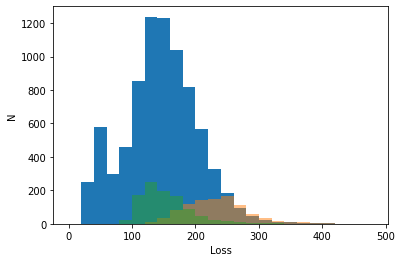

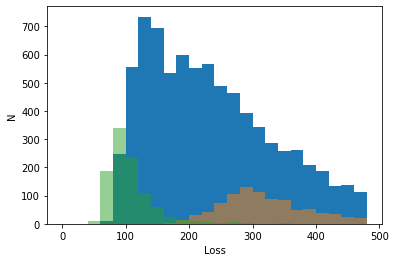

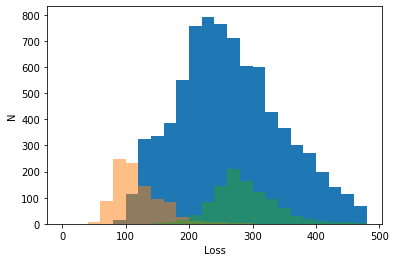

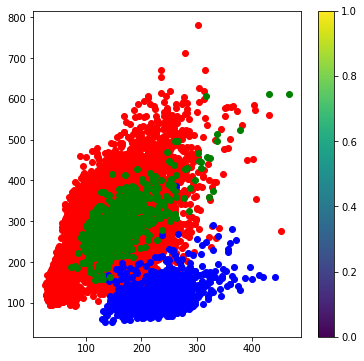

0.5169692321988325
0.35920200566164673
0.9257639976723779
0.9841300941950649
0.8100688509233824
0.9956606755417459


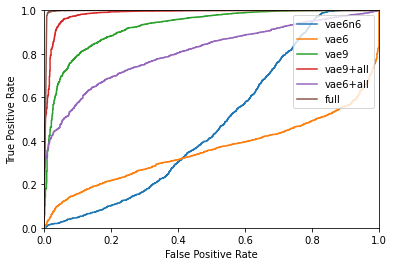

In [246]:
xn6_lossn6 = vaeloss(vaen6,x_ten6)
x6_lossn6  = vaeloss(vaen6,x_te6)
x9_lossn6  = vaeloss(vaen6,x_te9)
x_lossn6   = vaeloss(vaen6,x_te)

bins=np.arange(0,500,20)
plt.hist(xn6_lossn6,bins)
plt.hist(x6_lossn6,bins,alpha=0.5)
plt.hist(x9_lossn6,bins,alpha=0.5)
plt.xlabel('Loss') 
plt.ylabel('N') 
plt.show()

#Lets compute the VAE Loss for 5,6 and 9
xn6_loss9 = vaeloss(vae9,x_ten6)
x6_loss9  = vaeloss(vae9,x_te6)
x9_loss9  = vaeloss(vae9,x_te9)
x_loss9   = vaeloss(vae9,x_te)

bins=np.arange(0,500,20)
plt.hist(xn6_loss9,bins)
plt.hist(x6_loss9,bins,alpha=0.5)
plt.hist(x9_loss9,bins,alpha=0.5)
plt.xlabel('Loss') 
plt.ylabel('N') 
plt.show()

#Lets compute the VAE Loss for 5 and 9
xn6_loss6 = vaeloss(vae6,x_ten6)
x6_loss6  = vaeloss(vae6,x_te6)
x9_loss6  = vaeloss(vae6,x_te9)
x_loss6   = vaeloss(vae6,x_te)

bins=np.arange(0,500,20)
plt.hist(xn6_loss6,bins)
plt.hist(x6_loss6,bins,alpha=0.5)
plt.hist(x9_loss6,bins,alpha=0.5)
plt.xlabel('Loss') 
plt.ylabel('N') 
plt.show()

#Lets now make the 2D plot
plt.figure(figsize=(6, 6))
plt.scatter(xn6_lossn6, xn6_loss6, c='r')
plt.scatter(x6_lossn6,  x6_loss6, c='b')
plt.scatter(x9_lossn6,  x9_loss6, c='g')
plt.colorbar()
plt.show()


#Now some rocs, lets compare the single VAE loss with the double loss and full
y_pred_loss9n6 = model_loss9n6.predict(x_te_loss9n6)
y_pred_loss6n6 = model_loss6n6.predict(x_te_loss6n6)
y_pred_full6n6 = model_full6n6.predict(x_te)

plot_roc_curve(x_lossn6,y_teI9,fpr,tpr,'vae6n6',True)
plot_roc_curve(x_loss6 ,y_teI9,fpr,tpr,'vae6',False)
plot_roc_curve(x_loss9 ,y_teI9,fpr,tpr,'vae9',True)

plot_roc_curve(y_pred_loss9n6[:,0],y_teI9,fpr,tpr,'vae9+all',True)
plot_roc_curve(y_pred_loss6n6[:,0],y_teI9,fpr,tpr,'vae6+all',True)
plot_roc_curve(y_pred_full6n6[:,0],y_teI9,fpr,tpr,'full',True)
plt.legend(loc="upper right")
plt.show()

In [249]:
#Now finally lets do the same search with an AE on each digit
vaeN = []
vaeLoss_tr = []
vaeLoss_te = []
for i0 in range(8):
    tmpx_te = x_te[(y_te == i0)]
    tmpy_te = y_te[(y_te == i0)]
    tmpx_tr = x_tr[(y_tr == i0)]
    tmpy_tr = y_tr[(y_tr == i0)]
    tmpvae,tmpgen,tmpx,tmpy,tmpmu,tmpvae_loss = makeModel(tmpx_tr)
    tmpvae.fit(tmpx_tr,
               shuffle=True,
               epochs=10,
               batch_size=batch_size,
               validation_data=(tmpx_te, None), verbose=1)
    vaeN.append(tmpvae)
    x_tr_vaeLoss = vaeloss(tmpvae,x_tr)
    x_te_vaeLoss = vaeloss(tmpvae,x_te)
    vaeLoss_tr.append(x_tr_vaeLoss)
    vaeLoss_te.append(x_te_vaeLoss)

    

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_324 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_324.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 5923 samples, validate on 980 samples
Epoch 1/10
5923/5923 [==============================] - 15s 2ms/step - loss: 147.4246 - val_loss: 132.4322
Epoch 2/10
5923/5923 [==============================] - 14s 2ms/step - loss: 132.0513 - val_loss: 129.9350
Epoch 3/10
5923/5923 [==============================] - 13s 2ms/step - loss: 130.2125 - val_loss: 129.7319
Epoch 4/10
5923/5923 [==============================] - 14s 2ms/step - loss: 129.5336 - val_loss: 128.1403
Epoch 5/10
5923/5923 [==============================] - 11s 2ms/step - loss: 129.3042 - val_loss: 127.9916
Epoch 6/10
5923/5923 [==============================] - 11s 2ms/step - loss: 129.3979 - val_loss: 128.8196
Epoch 7/10
5923/5923 [==============================] - 11s 2ms/step - loss: 129.4942 - val_loss: 129.1520
Epoch 8/10
5923/5923 [==============================] - 13s 2ms/step - loss: 129.5313 - val_loss: 129.0912
Epoch 9/10
5923/5923 [==============================] - 12s 2ms/step - loss: 129.6275 - val_loss:

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_331 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_331.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 6742 samples, validate on 1135 samples
Epoch 1/10
6742/6742 [==============================] - 15s 2ms/step - loss: 54.3054 - val_loss: 45.9728
Epoch 2/10
6742/6742 [==============================] - 15s 2ms/step - loss: 46.7589 - val_loss: 44.7945
Epoch 3/10
6742/6742 [==============================] - 15s 2ms/step - loss: 46.0361 - val_loss: 44.6923
Epoch 4/10
6742/6742 [==============================] - 13s 2ms/step - loss: 45.8740 - val_loss: 45.1690
Epoch 5/10
6742/6742 [==============================] - 13s 2ms/step - loss: 45.9538 - val_loss: 44.5747
Epoch 6/10
6742/6742 [==============================] - 13s 2ms/step - loss: 46.0169 - val_loss: 45.0037
Epoch 7/10
6742/6742 [==============================] - 14s 2ms/step - loss: 46.2027 - val_loss: 44.8823
Epoch 8/10
6742/6742 [==============================] - 13s 2ms/step - loss: 46.3621 - val_loss: 44.9438
Epoch 9/10
6742/6742 [==============================] - 13s 2ms/step - loss: 46.5687 - val_loss: 45.0839
Epoch 1

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_338 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_338.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 5958 samples, validate on 1032 samples
Epoch 1/10
5958/5958 [==============================] - 12s 2ms/step - loss: 165.9173 - val_loss: 152.7210
Epoch 2/10
5958/5958 [==============================] - 12s 2ms/step - loss: 153.4451 - val_loss: 148.8919
Epoch 3/10
5958/5958 [==============================] - 12s 2ms/step - loss: 151.7417 - val_loss: 148.9240
Epoch 4/10
5958/5958 [==============================] - 15s 2ms/step - loss: 151.1736 - val_loss: 148.8873
Epoch 5/10
5958/5958 [==============================] - 13s 2ms/step - loss: 150.7828 - val_loss: 148.0954
Epoch 6/10
5958/5958 [==============================] - 13s 2ms/step - loss: 150.7224 - val_loss: 148.6416
Epoch 7/10
5958/5958 [==============================] - 12s 2ms/step - loss: 150.8203 - val_loss: 148.4147
Epoch 8/10
5958/5958 [==============================] - 13s 2ms/step - loss: 150.6621 - val_loss: 148.8870
Epoch 9/10
5958/5958 [==============================] - 13s 2ms/step - loss: 150.7399 - val_loss

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_345 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_345.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 6131 samples, validate on 1010 samples
Epoch 1/10
6131/6131 [==============================] - 14s 2ms/step - loss: 146.4458 - val_loss: 135.1341
Epoch 2/10
6131/6131 [==============================] - 13s 2ms/step - loss: 136.5384 - val_loss: 135.5305
Epoch 3/10
6131/6131 [==============================] - 13s 2ms/step - loss: 135.9691 - val_loss: 134.6357
Epoch 4/10
6131/6131 [==============================] - 13s 2ms/step - loss: 136.0829 - val_loss: 134.4873
Epoch 5/10
6131/6131 [==============================] - 15s 2ms/step - loss: 136.5379 - val_loss: 133.8512
Epoch 6/10
6131/6131 [==============================] - 14s 2ms/step - loss: 136.7331 - val_loss: 135.9151
Epoch 7/10
6131/6131 [==============================] - 12s 2ms/step - loss: 136.9908 - val_loss: 135.5160
Epoch 8/10
6131/6131 [==============================] - 13s 2ms/step - loss: 137.2334 - val_loss: 135.9724
Epoch 9/10
6131/6131 [==============================] - 15s 2ms/step - loss: 137.4212 - val_loss

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_352 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_352.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 5842 samples, validate on 982 samples
Epoch 1/10
5842/5842 [==============================] - 16s 3ms/step - loss: 132.1811 - val_loss: 121.5053
Epoch 2/10
5842/5842 [==============================] - 15s 2ms/step - loss: 120.4849 - val_loss: 118.5971
Epoch 3/10
5842/5842 [==============================] - 14s 2ms/step - loss: 119.4120 - val_loss: 118.9347
Epoch 4/10
5842/5842 [==============================] - 15s 3ms/step - loss: 119.2079 - val_loss: 118.5753
Epoch 5/10
5842/5842 [==============================] - 14s 2ms/step - loss: 119.3717 - val_loss: 118.2089
Epoch 6/10
5842/5842 [==============================] - 15s 3ms/step - loss: 119.4158 - val_loss: 119.5630
Epoch 7/10
5842/5842 [==============================] - 14s 2ms/step - loss: 119.7121 - val_loss: 118.5276
Epoch 8/10
5842/5842 [==============================] - 16s 3ms/step - loss: 119.6952 - val_loss: 118.9954
Epoch 9/10
5842/5842 [==============================] - 13s 2ms/step - loss: 119.8496 - val_loss:

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_359 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_359.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 5421 samples, validate on 892 samples
Epoch 1/10
5421/5421 [==============================] - 14s 3ms/step - loss: 145.5269 - val_loss: 134.7985
Epoch 2/10
5421/5421 [==============================] - 14s 3ms/step - loss: 133.3995 - val_loss: 132.0104
Epoch 3/10
5421/5421 [==============================] - 13s 2ms/step - loss: 132.0517 - val_loss: 131.8190
Epoch 4/10
5421/5421 [==============================] - 13s 2ms/step - loss: 131.8542 - val_loss: 131.9126
Epoch 5/10
5421/5421 [==============================] - 14s 3ms/step - loss: 131.9223 - val_loss: 134.9314
Epoch 6/10
5421/5421 [==============================] - 15s 3ms/step - loss: 132.1843 - val_loss: 132.3055
Epoch 7/10
5421/5421 [==============================] - 15s 3ms/step - loss: 132.2736 - val_loss: 133.1286
Epoch 8/10
5421/5421 [==============================] - 14s 3ms/step - loss: 132.4304 - val_loss: 132.7261
Epoch 9/10
5421/5421 [==============================] - 13s 2ms/step - loss: 132.6721 - val_loss:

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_366 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_366.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 5918 samples, validate on 958 samples
Epoch 1/10
5918/5918 [==============================] - 14s 2ms/step - loss: 127.1418 - val_loss: 122.9403
Epoch 2/10
5918/5918 [==============================] - 14s 2ms/step - loss: 116.8159 - val_loss: 118.2245
Epoch 3/10
5918/5918 [==============================] - 14s 2ms/step - loss: 115.6101 - val_loss: 117.8049
Epoch 4/10
5918/5918 [==============================] - 15s 2ms/step - loss: 115.2274 - val_loss: 117.6803
Epoch 5/10
5918/5918 [==============================] - 15s 3ms/step - loss: 115.1997 - val_loss: 118.1919
Epoch 6/10
5918/5918 [==============================] - 13s 2ms/step - loss: 115.1868 - val_loss: 119.1655
Epoch 7/10
5918/5918 [==============================] - 14s 2ms/step - loss: 115.2232 - val_loss: 119.8180
Epoch 8/10
5918/5918 [==============================] - 15s 3ms/step - loss: 115.4875 - val_loss: 119.5212
Epoch 9/10
5918/5918 [==============================] - 14s 2ms/step - loss: 115.4793 - val_loss:

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_373 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_373.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 6265 samples, validate on 1028 samples
Epoch 1/10
6265/6265 [==============================] - 15s 2ms/step - loss: 114.3303 - val_loss: 103.2491
Epoch 2/10
6265/6265 [==============================] - 14s 2ms/step - loss: 102.9471 - val_loss: 101.2050
Epoch 3/10
6265/6265 [==============================] - 16s 3ms/step - loss: 101.9064 - val_loss: 100.5644
Epoch 4/10
6265/6265 [==============================] - 15s 2ms/step - loss: 101.9576 - val_loss: 101.6060
Epoch 5/10
6265/6265 [==============================] - 14s 2ms/step - loss: 102.1383 - val_loss: 101.9986
Epoch 6/10
6265/6265 [==============================] - 14s 2ms/step - loss: 102.5431 - val_loss: 102.0306
Epoch 7/10
6265/6265 [==============================] - 15s 2ms/step - loss: 102.9275 - val_loss: 101.5604
Epoch 8/10
6265/6265 [==============================] - 14s 2ms/step - loss: 103.0497 - val_loss: 103.5717
Epoch 9/10
6265/6265 [==============================] - 14s 2ms/step - loss: 103.4124 - val_loss

In [265]:
x_te_lossN    = np.transpose(np.array(vaeLoss_te))
x_tr_lossN    = np.transpose(np.array(vaeLoss_tr))
print(x_tr_lossN.shape,y_tr.shape)
x_tr_lossNn9,y_trn9 = random_sample(x_tr_lossN,y_tr )
x_te_lossNn9,y_ten9 = random_sample(x_te_lossN,y_te )

x_tr_lossN9 = x_tr_lossN[(y_tr==9)]
x_te_lossN9 = x_te_lossN[(y_te==9)]

##now merge with 9
x_tr9RB = np.concatenate((x_tr_lossNn9,x_tr_lossN9))
x_te9RB = np.concatenate((x_te_lossNn9,x_te_lossN9))
y_tr9RB = np.concatenate((y_trn9,y_tr9))
y_te9RB = np.concatenate((y_ten9,y_te9))
y_teI9RB = np.eye(2)[((y_te9RB==9)).astype(int)]
y_trI9RB = np.eye(2)[((y_tr9RB==9)).astype(int)]

model_lossN,x_lossN,y_lossN = classifierModel(x_tr9RB)
model_lossN.fit(x_tr9RB,y_trI9RB,
                  shuffle=True,
                  epochs=200,
                  batch_size=100,
                  validation_data=(x_te9RB, y_teI9RB), verbose=1)

(60000, 8) (60000,)
Train on 17949 samples, validate on 3009 samples
Epoch 1/200
17949/17949 [==============================] - 0s 24us/step - loss: 0.3954 - accuracy: 0.8378 - val_loss: 0.2408 - val_accuracy: 0.9010
Epoch 2/200
17949/17949 [==============================] - 0s 15us/step - loss: 0.2494 - accuracy: 0.8998 - val_loss: 0.2166 - val_accuracy: 0.9279
Epoch 3/200
17949/17949 [==============================] - 0s 14us/step - loss: 0.1811 - accuracy: 0.9323 - val_loss: 0.1716 - val_accuracy: 0.9418
Epoch 4/200
17949/17949 [==============================] - 0s 16us/step - loss: 0.1701 - accuracy: 0.9383 - val_loss: 0.1627 - val_accuracy: 0.9415
Epoch 5/200
17949/17949 [==============================] - 0s 14us/step - loss: 0.1689 - accuracy: 0.9375 - val_loss: 0.1707 - val_accuracy: 0.9372
Epoch 6/200
17949/17949 [==============================] - 0s 13us/step - loss: 0.1574 - accuracy: 0.9419 - val_loss: 0.1695 - val_accuracy: 0.9355
Epoch 7/200
17949/17949 [==================

17949/17949 [==============================] - 0s 13us/step - loss: 0.1203 - accuracy: 0.9544 - val_loss: 0.1389 - val_accuracy: 0.9495
Epoch 56/200
17949/17949 [==============================] - 0s 14us/step - loss: 0.1130 - accuracy: 0.9579 - val_loss: 0.1447 - val_accuracy: 0.9488
Epoch 57/200
17949/17949 [==============================] - 0s 14us/step - loss: 0.1167 - accuracy: 0.9546 - val_loss: 0.1260 - val_accuracy: 0.9541
Epoch 58/200
17949/17949 [==============================] - 0s 13us/step - loss: 0.1147 - accuracy: 0.9572 - val_loss: 0.1243 - val_accuracy: 0.9545
Epoch 59/200
17949/17949 [==============================] - 0s 13us/step - loss: 0.1116 - accuracy: 0.9580 - val_loss: 0.1333 - val_accuracy: 0.9498
Epoch 60/200
17949/17949 [==============================] - 0s 13us/step - loss: 0.1133 - accuracy: 0.9579 - val_loss: 0.1318 - val_accuracy: 0.9521
Epoch 61/200
17949/17949 [==============================] - 0s 13us/step - loss: 0.1096 - accuracy: 0.9602 - val_loss: 

17949/17949 [==============================] - 0s 14us/step - loss: 0.0981 - accuracy: 0.9634 - val_loss: 0.1269 - val_accuracy: 0.9568
Epoch 111/200
17949/17949 [==============================] - 0s 14us/step - loss: 0.0946 - accuracy: 0.9647 - val_loss: 0.1347 - val_accuracy: 0.9485
Epoch 112/200
17949/17949 [==============================] - 0s 15us/step - loss: 0.0955 - accuracy: 0.9648 - val_loss: 0.1293 - val_accuracy: 0.9518
Epoch 113/200
17949/17949 [==============================] - 0s 15us/step - loss: 0.0962 - accuracy: 0.9643 - val_loss: 0.1310 - val_accuracy: 0.9531
Epoch 114/200
17949/17949 [==============================] - 0s 15us/step - loss: 0.0958 - accuracy: 0.9643 - val_loss: 0.1324 - val_accuracy: 0.9498
Epoch 115/200
17949/17949 [==============================] - 0s 14us/step - loss: 0.0972 - accuracy: 0.9640 - val_loss: 0.1285 - val_accuracy: 0.9528
Epoch 116/200
17949/17949 [==============================] - 0s 14us/step - loss: 0.0968 - accuracy: 0.9636 - val_

Epoch 165/200
17949/17949 [==============================] - 0s 14us/step - loss: 0.0838 - accuracy: 0.9681 - val_loss: 0.1435 - val_accuracy: 0.9501
Epoch 166/200
17949/17949 [==============================] - 0s 14us/step - loss: 0.0860 - accuracy: 0.9674 - val_loss: 0.1297 - val_accuracy: 0.9568
Epoch 167/200
17949/17949 [==============================] - 0s 14us/step - loss: 0.0854 - accuracy: 0.9677 - val_loss: 0.1368 - val_accuracy: 0.9558
Epoch 168/200
17949/17949 [==============================] - 0s 14us/step - loss: 0.0812 - accuracy: 0.9698 - val_loss: 0.1378 - val_accuracy: 0.9525
Epoch 169/200
17949/17949 [==============================] - 0s 14us/step - loss: 0.0851 - accuracy: 0.9680 - val_loss: 0.1356 - val_accuracy: 0.9548
Epoch 170/200
17949/17949 [==============================] - 0s 14us/step - loss: 0.0828 - accuracy: 0.9683 - val_loss: 0.1438 - val_accuracy: 0.9541
Epoch 171/200
17949/17949 [==============================] - 0s 15us/step - loss: 0.0829 - accuracy:

0.988070660683809
0.9841300941950649
0.8100688509233824
0.9956606755417459


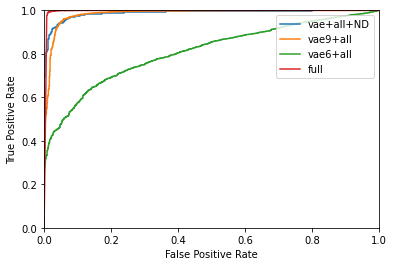

In [266]:
#Now some rocs, lets compare the single VAE loss with the double loss and full
y_pred_lossN = model_lossN.predict(x_te_lossN)

plot_roc_curve(y_pred_lossN  [:,0],y_teI9,fpr,tpr,'vae+all+ND',True)
plot_roc_curve(y_pred_loss9n6[:,0],y_teI9,fpr,tpr,'vae9+all',True)
plot_roc_curve(y_pred_loss6n6[:,0],y_teI9,fpr,tpr,'vae6+all',True)
plot_roc_curve(y_pred_full6n6[:,0],y_teI9,fpr,tpr,'full',True)
plt.legend(loc="upper right")
plt.show()

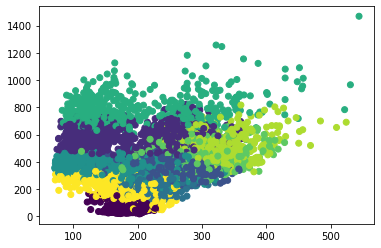

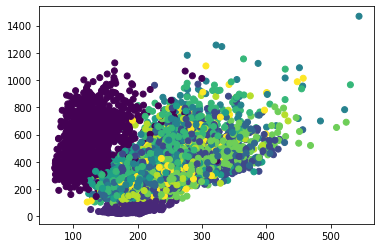

In [317]:
#Now the question is can we find an anamoly
#plt.figure(figsize=(6, 6))
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(x_te_lossN[:,1], x_te_lossN[:, 6], x_te_lossN[:, 7], c=y_te)
#plt.show()

#from sklearn import metrics
#Lets look for it in DB scan
#from sklearn.cluster import DBSCAN
#db = DBSCAN(eps=500, min_samples=100).fit(x_te_lossN)
#core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#core_samples_mask[db.core_sample_indices_] = True
#labels = db.labels_
#n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
#n_noise_ = list(labels).count(-1)

#print('Estimated number of clusters:',n_clusters_)
#print('Estimated number of noise points: ',  n_noise_)

#from sklearn.cluster import AffinityPropagation
#af = AffinityPropagation(preference=-50).fit(x_te_lossN)
#cluster_centers_indices = af.cluster_centers_indices_
#labels = af.labels_
#n_clusters_ = len(cluster_centers_indices)
#print('Estimated number of clusters: %d' % n_clusters_)

from sklearn.cluster import KMeans
y_te_kmeans = KMeans(n_clusters=9).fit_predict(x_te_lossN)
plt.scatter(x_te_lossN[:, 0], x_te_lossN[:, 1], c=y_te_kmeans)
plt.show()
plt.scatter(x_te_lossN[:, 0], x_te_lossN[:, 1], c=y_te)
plt.show()


0.988070660683809
0.7651628062375777


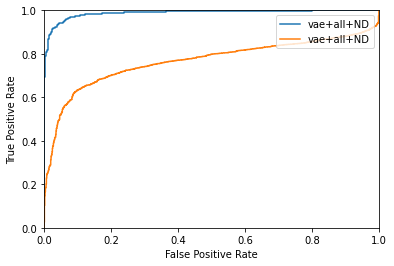

In [413]:
#hmm clustering doesn't seem to help too much, lets consider building a simple metric to approach the NN
y_predAna_lossN = x_te_lossN[:,7]#np.product(x_te_lossN,axis=1)
#y_predAna_lossN = model_lossN.predict(x_te_lossN)
plot_roc_curve(y_pred_lossN     [:,0],y_teI9,fpr,tpr,'vae+all+ND',True)
plot_roc_curve(y_predAna_lossN  ,y_teI9,fpr,tpr,'vae+all+ND',True)
plt.legend(loc="upper right")
plt.show()

In [414]:
#We never trained 8
tmpx_te = x_te[(y_te == 8)]
tmpy_te = y_te[(y_te == 8)]
tmpx_tr = x_tr[(y_tr == 8)]
tmpy_tr = y_tr[(y_tr == 8)]
tmpvae,tmpgen,tmpx,tmpy,tmpmu,tmpvae_loss = makeModel(tmpx_tr)
tmpvae.fit(tmpx_tr,shuffle=True,epochs=10,batch_size=batch_size,validation_data=(tmpx_te, None), verbose=1)


/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_416 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_416.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 5851 samples, validate on 974 samples
Epoch 1/10
5851/5851 [==============================] - 13s 2ms/step - loss: 151.1670 - val_loss: 142.7508
Epoch 2/10
5851/5851 [==============================] - 13s 2ms/step - loss: 140.4940 - val_loss: 144.1382
Epoch 3/10
5851/5851 [==============================] - 13s 2ms/step - loss: 139.4427 - val_loss: 140.6219
Epoch 4/10
5851/5851 [==============================] - 13s 2ms/step - loss: 139.2302 - val_loss: 140.7952
Epoch 5/10
5851/5851 [==============================] - 13s 2ms/step - loss: 139.3604 - val_loss: 141.8690
Epoch 6/10
5851/5851 [==============================] - 13s 2ms/step - loss: 139.5840 - val_loss: 141.7347
Epoch 7/10
5851/5851 [==============================] - 13s 2ms/step - loss: 139.7932 - val_loss: 142.1785
Epoch 8/10
5851/5851 [==============================] - 13s 2ms/step - loss: 139.9542 - val_loss: 141.6278
Epoch 9/10
5851/5851 [==============================] - 13s 2ms/step - loss: 140.0480 - val_loss:

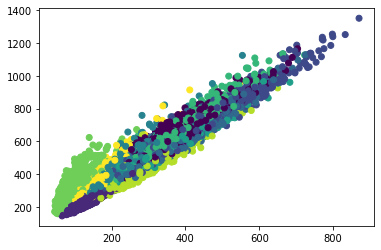

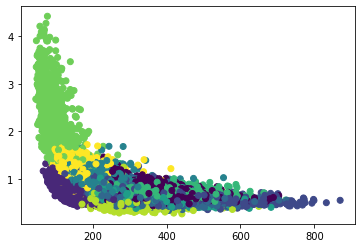

In [428]:
#some thoughts on projecting
x_te_loss8 = vaeloss(tmpvae,x_te)
plt.scatter(x_te_lossN[:, 7], x_te_loss8+x_te_lossN[:, 7], c=y_te)
plt.show()
plt.scatter(x_te_lossN[:, 7], x_te_loss8/x_te_lossN[:, 7], c=y_te)
#seems like the bottom one is more discriminat

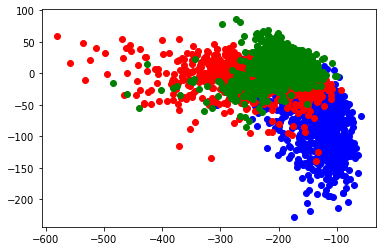

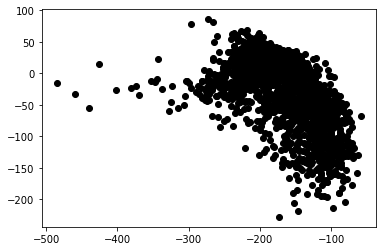

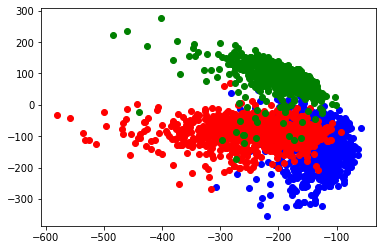

Train on 11339 samples, validate on 1850 samples
Epoch 1/200
11339/11339 [==============================] - 0s 29us/step - loss: 1.0136 - accuracy: 0.8294 - val_loss: 0.3494 - val_accuracy: 0.8649
Epoch 2/200
11339/11339 [==============================] - 0s 13us/step - loss: 0.3275 - accuracy: 0.8690 - val_loss: 0.3049 - val_accuracy: 0.8757
Epoch 3/200
11339/11339 [==============================] - 0s 15us/step - loss: 0.3267 - accuracy: 0.8707 - val_loss: 0.3767 - val_accuracy: 0.8459
Epoch 4/200
11339/11339 [==============================] - 0s 13us/step - loss: 0.3231 - accuracy: 0.8697 - val_loss: 0.3628 - val_accuracy: 0.8508
Epoch 5/200
11339/11339 [==============================] - 0s 14us/step - loss: 0.3103 - accuracy: 0.8747 - val_loss: 0.3088 - val_accuracy: 0.8724
Epoch 6/200
11339/11339 [==============================] - 0s 15us/step - loss: 0.3152 - accuracy: 0.8757 - val_loss: 0.2862 - val_accuracy: 0.8768
Epoch 7/200
11339/11339 [==============================] - 0s 1

Epoch 56/200
11339/11339 [==============================] - 0s 12us/step - loss: 0.2748 - accuracy: 0.8843 - val_loss: 0.2783 - val_accuracy: 0.8773
Epoch 57/200
11339/11339 [==============================] - 0s 13us/step - loss: 0.2744 - accuracy: 0.8831 - val_loss: 0.2711 - val_accuracy: 0.8827
Epoch 58/200
11339/11339 [==============================] - 0s 13us/step - loss: 0.2741 - accuracy: 0.8863 - val_loss: 0.2789 - val_accuracy: 0.8789
Epoch 59/200
11339/11339 [==============================] - 0s 13us/step - loss: 0.2739 - accuracy: 0.8849 - val_loss: 0.2914 - val_accuracy: 0.8719
Epoch 60/200
11339/11339 [==============================] - 0s 13us/step - loss: 0.2751 - accuracy: 0.8812 - val_loss: 0.2732 - val_accuracy: 0.8838
Epoch 61/200
11339/11339 [==============================] - 0s 13us/step - loss: 0.2774 - accuracy: 0.8832 - val_loss: 0.2795 - val_accuracy: 0.8816
Epoch 62/200
11339/11339 [==============================] - 0s 13us/step - loss: 0.2759 - accuracy: 0.8854

Epoch 111/200
11339/11339 [==============================] - 0s 12us/step - loss: 0.2669 - accuracy: 0.8862 - val_loss: 0.2744 - val_accuracy: 0.8789
Epoch 112/200
11339/11339 [==============================] - 0s 12us/step - loss: 0.2657 - accuracy: 0.8883 - val_loss: 0.2661 - val_accuracy: 0.8800
Epoch 113/200
11339/11339 [==============================] - 0s 12us/step - loss: 0.2674 - accuracy: 0.8860 - val_loss: 0.2704 - val_accuracy: 0.8805
Epoch 114/200
11339/11339 [==============================] - 0s 11us/step - loss: 0.2683 - accuracy: 0.8854 - val_loss: 0.2737 - val_accuracy: 0.8784
Epoch 115/200
11339/11339 [==============================] - 0s 11us/step - loss: 0.2661 - accuracy: 0.8883 - val_loss: 0.2630 - val_accuracy: 0.8832
Epoch 116/200
11339/11339 [==============================] - 0s 12us/step - loss: 0.2685 - accuracy: 0.8870 - val_loss: 0.2622 - val_accuracy: 0.8876
Epoch 117/200
11339/11339 [==============================] - 0s 12us/step - loss: 0.2668 - accuracy:

11339/11339 [==============================] - 0s 13us/step - loss: 0.2639 - accuracy: 0.8879 - val_loss: 0.2591 - val_accuracy: 0.8816
Epoch 166/200
11339/11339 [==============================] - 0s 13us/step - loss: 0.2619 - accuracy: 0.8861 - val_loss: 0.2655 - val_accuracy: 0.8811
Epoch 167/200
11339/11339 [==============================] - 0s 12us/step - loss: 0.2647 - accuracy: 0.8877 - val_loss: 0.2669 - val_accuracy: 0.8816
Epoch 168/200
11339/11339 [==============================] - 0s 12us/step - loss: 0.2633 - accuracy: 0.8878 - val_loss: 0.2659 - val_accuracy: 0.8822
Epoch 169/200
11339/11339 [==============================] - 0s 12us/step - loss: 0.2626 - accuracy: 0.8873 - val_loss: 0.2653 - val_accuracy: 0.8827
Epoch 170/200
11339/11339 [==============================] - 0s 12us/step - loss: 0.2641 - accuracy: 0.8869 - val_loss: 0.2643 - val_accuracy: 0.8822
Epoch 171/200
11339/11339 [==============================] - 0s 13us/step - loss: 0.2627 - accuracy: 0.8879 - val_

11370/11370 [==============================] - 0s 12us/step - loss: 8.0466 - accuracy: 0.4768 - val_loss: 8.1405 - val_accuracy: 0.4692
Epoch 20/200
11370/11370 [==============================] - 0s 13us/step - loss: 8.0466 - accuracy: 0.4768 - val_loss: 8.1405 - val_accuracy: 0.4692
Epoch 21/200
11370/11370 [==============================] - 0s 12us/step - loss: 8.0466 - accuracy: 0.4768 - val_loss: 8.1405 - val_accuracy: 0.4692
Epoch 22/200
11370/11370 [==============================] - 0s 13us/step - loss: 8.0466 - accuracy: 0.4768 - val_loss: 8.1405 - val_accuracy: 0.4692
Epoch 23/200
11370/11370 [==============================] - 0s 12us/step - loss: 8.0466 - accuracy: 0.4768 - val_loss: 8.1405 - val_accuracy: 0.4692
Epoch 24/200
11370/11370 [==============================] - 0s 13us/step - loss: 8.0466 - accuracy: 0.4768 - val_loss: 8.1405 - val_accuracy: 0.4692
Epoch 25/200
11370/11370 [==============================] - 0s 13us/step - loss: 8.0466 - accuracy: 0.4768 - val_loss: 

11370/11370 [==============================] - 0s 12us/step - loss: 8.0466 - accuracy: 0.4768 - val_loss: 8.1405 - val_accuracy: 0.4692
Epoch 75/200
11370/11370 [==============================] - 0s 12us/step - loss: 8.0466 - accuracy: 0.4768 - val_loss: 8.1405 - val_accuracy: 0.4692
Epoch 76/200
11370/11370 [==============================] - 0s 11us/step - loss: 8.0466 - accuracy: 0.4768 - val_loss: 8.1405 - val_accuracy: 0.4692
Epoch 77/200
11370/11370 [==============================] - 0s 11us/step - loss: 8.0466 - accuracy: 0.4768 - val_loss: 8.1405 - val_accuracy: 0.4692
Epoch 78/200
11370/11370 [==============================] - 0s 12us/step - loss: 8.0466 - accuracy: 0.4768 - val_loss: 8.1405 - val_accuracy: 0.4692
Epoch 79/200
11370/11370 [==============================] - 0s 11us/step - loss: 8.0466 - accuracy: 0.4768 - val_loss: 8.1405 - val_accuracy: 0.4692
Epoch 80/200
11370/11370 [==============================] - 0s 11us/step - loss: 8.0466 - accuracy: 0.4768 - val_loss: 

Epoch 129/200
11370/11370 [==============================] - 0s 16us/step - loss: 8.0466 - accuracy: 0.4768 - val_loss: 8.1405 - val_accuracy: 0.4692
Epoch 130/200
11370/11370 [==============================] - 0s 14us/step - loss: 8.0466 - accuracy: 0.4768 - val_loss: 8.1405 - val_accuracy: 0.4692
Epoch 131/200
11370/11370 [==============================] - 0s 13us/step - loss: 8.0466 - accuracy: 0.4768 - val_loss: 8.1405 - val_accuracy: 0.4692
Epoch 132/200
11370/11370 [==============================] - 0s 13us/step - loss: 8.0466 - accuracy: 0.4768 - val_loss: 8.1405 - val_accuracy: 0.4692
Epoch 133/200
11370/11370 [==============================] - 0s 13us/step - loss: 8.0466 - accuracy: 0.4768 - val_loss: 8.1405 - val_accuracy: 0.4692
Epoch 134/200
11370/11370 [==============================] - 0s 15us/step - loss: 8.0466 - accuracy: 0.4768 - val_loss: 8.1405 - val_accuracy: 0.4692
Epoch 135/200
11370/11370 [==============================] - 0s 14us/step - loss: 8.0466 - accuracy:

11370/11370 [==============================] - 0s 13us/step - loss: 8.0466 - accuracy: 0.4768 - val_loss: 8.1405 - val_accuracy: 0.4692
Epoch 184/200
11370/11370 [==============================] - 0s 13us/step - loss: 8.0466 - accuracy: 0.4768 - val_loss: 8.1405 - val_accuracy: 0.4692
Epoch 185/200
11370/11370 [==============================] - 0s 13us/step - loss: 8.0466 - accuracy: 0.4768 - val_loss: 8.1405 - val_accuracy: 0.4692
Epoch 186/200
11370/11370 [==============================] - 0s 13us/step - loss: 8.0466 - accuracy: 0.4768 - val_loss: 8.1405 - val_accuracy: 0.4692
Epoch 187/200
11370/11370 [==============================] - 0s 13us/step - loss: 8.0466 - accuracy: 0.4768 - val_loss: 8.1405 - val_accuracy: 0.4692
Epoch 188/200
11370/11370 [==============================] - 0s 14us/step - loss: 8.0466 - accuracy: 0.4768 - val_loss: 8.1405 - val_accuracy: 0.4692
Epoch 189/200
11370/11370 [==============================] - 0s 14us/step - loss: 8.0466 - accuracy: 0.4768 - val_

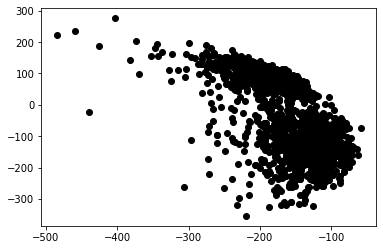

In [489]:
#Ok after playing a bit, lets get back to the point at hand. Lets assume we know 8 numbers. 
#That means we can separate out the different digits except for our mystery digit.
#Going back up to the top this reduces to our 5 vs 9 problem. 

#Lets compute the VAE Loss for 5
x5_loss5 = vaeloss(vae5,x_te5)
x6_loss5 = vaeloss(vae5,x_te6)
x9_loss5 = vaeloss(vae5,x_te9)
x59_loss5= vaeloss(vae5,x_te59)
x_te56_loss5= vaeloss(vae5,x_te56)
x_tr56_loss5= vaeloss(vae5,x_tr56)

#Lets compute the VAE Loss for 6
x5_loss6 = vaeloss(vaeN[3],x_te5)
x6_loss6 = vaeloss(vaeN[3],x_te6)
x9_loss6 = vaeloss(vaeN[3],x_te9)
x59_loss6= vaeloss(vaeN[3],x_te59)
x_te56_loss6= vaeloss(vaeN[3],x_te56)
x_tr56_loss6= vaeloss(vaeN[3],x_tr56)


#Lets compute the VAE Loss for 9
x5_loss9 = vaeloss(vae9,x_te5)
x6_loss9 = vaeloss(vae9,x_te6)
x9_loss9 = vaeloss(vae9,x_te9)
x59_loss9= vaeloss(vae9,x_te59)

#Lets look at 5 and 6
plt.scatter(-x5_loss5, -x5_loss6+x5_loss5,c='blue')
plt.scatter(-x6_loss5, -x6_loss6+x6_loss5,c='red')
plt.scatter(-x9_loss5, -x9_loss6+x9_loss5,c='green')
plt.show()

#Now lets plot the signal 
plt.scatter(-x59_loss5, -x59_loss6+x59_loss5,c='black')
plt.show()

#Lets look at 5 and 6
plt.scatter(-x5_loss5, -x5_loss9+x5_loss5,c='blue')
plt.scatter(-x6_loss5, -x6_loss9+x6_loss5,c='red')
plt.scatter(-x9_loss5, -x9_loss9+x9_loss5,c='green')
plt.show()

#Now lets plot the signal 
plt.scatter(-x59_loss5, -x59_loss9+x59_loss5,c='black')

#Merge 3 and 6 
x_te56_loss53    = np.transpose(np.array([x_te56_loss6,x_te56_loss5]))
x_tr56_loss53    = np.transpose(np.array([x_tr56_loss6,x_tr56_loss5]))

#Finally we do the training
model_56loss53,x_56loss53,y_56loss53 = classifierModel(x_tr56_loss53)
model_56loss53.fit(x_tr56_loss53,y_tr56,
                   shuffle=True,
                   epochs=200,
                   batch_size=100,
                   validation_data=(x_te56_loss53, y_te56), verbose=1)
#Merge 3 and 6 
x_te59_loss53rt    = np.transpose(np.array([x_te59_loss6,x_te59_loss5]))
x_tr59_loss53rt    = np.transpose(np.array([x_tr59_loss6,x_tr59_loss5]))

#Finally we do the training
model_59loss53rt,x_59loss53rt,y_59loss53rt = classifierModel(x_tr59_loss53rt)
model_59loss53rt.fit(x_tr59_loss53rt,y_tr59,
                     shuffle=True,
                     epochs=200,
                     batch_size=100,
                     validation_data=(x_te59_loss53rt, y_te59), verbose=1)



Train on 11370 samples, validate on 1901 samples
Epoch 1/50
11370/11370 [==============================] - 1s 111us/step - loss: 0.5053 - accuracy: 0.7896 - val_loss: 0.3473 - val_accuracy: 0.8485
Epoch 2/50
11370/11370 [==============================] - 1s 94us/step - loss: 0.3223 - accuracy: 0.8627 - val_loss: 0.3059 - val_accuracy: 0.8690
Epoch 3/50
11370/11370 [==============================] - 1s 101us/step - loss: 0.3091 - accuracy: 0.8699 - val_loss: 0.2957 - val_accuracy: 0.8806
Epoch 4/50
11370/11370 [==============================] - 1s 99us/step - loss: 0.3033 - accuracy: 0.8732 - val_loss: 0.2998 - val_accuracy: 0.8801
Epoch 5/50
11370/11370 [==============================] - 1s 94us/step - loss: 0.3032 - accuracy: 0.8731 - val_loss: 0.2914 - val_accuracy: 0.8843
Epoch 6/50
11370/11370 [==============================] - 1s 95us/step - loss: 0.3014 - accuracy: 0.8723 - val_loss: 0.2878 - val_accuracy: 0.8869
Epoch 7/50
11370/11370 [==============================] - 1s 94us/s

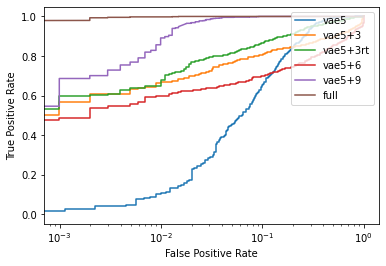

In [499]:
def plot_invroc_curve(y_ml,y,fpr,tpr,iLabel,iReverse=False):
    fpr , tpr , thresholds = roc_curve ( y[:,0] , y_ml)
    #plt.semilogx(fpr,tpr) 
    #tpr=1./(1.-tpr)
    #tpr[np.isinf(tpr)]=0
    #print(tpr)
    if iReverse:
        plt.semilogx(fpr,tpr,label=iLabel) 
    else:
        plt.semilogx(tpr,fpr,label=iLabel) 
    #plt.axis([0,1,0,1]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    auc_score=roc_auc_score( y[:,0], y_ml)  #0.8822
    print(auc_score)

model_59loss53rt,x_59loss53rt,y_59loss53rt = classifierModel(x_tr59_loss53rt)
model_59loss53rt.fit(x_tr59_loss53rt,y_tr59,
                     shuffle=True,
                     epochs=50,
                     batch_size=10,
                     validation_data=(x_te59_loss53rt, y_te59), verbose=1)


x_te59_loss53    = np.transpose(np.array([x_te59_loss6,x_te59_loss5]))

#Now some rocs, lets compare the single VAE loss with the double loss and full
#y_pred_loss56_tmp = y_pred_loss53
y_pred_loss53 = model_56loss53.predict(x_te59_loss53)
y_pred_loss53rt = model_59loss53rt.predict(x_te59_loss53)

plot_invroc_curve(x59_loss5,y_te59,fpr,tpr,'vae5')
plot_invroc_curve(y_pred_loss53[:,0],y_te59,fpr,tpr,'vae5+3',True)
plot_invroc_curve(y_pred_loss53rt[:,0],y_te59,fpr,tpr,'vae5+3rt',True)
plot_invroc_curve(y_pred_loss56_tmp[:,0],y_te59,fpr,tpr,'vae5+6',True)
plot_invroc_curve(y_pred_loss59[:,0],y_te59,fpr,tpr,'vae5+9',True)
plot_invroc_curve(y_pred_full59[:,0],y_te59,fpr,tpr,'full',True)
plt.legend(loc="upper right")
plt.show()